# Principal component analysis

## Import libraries

In [1]:
import os
import os.path as op
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn.plotting import plot_stat_map, show
from nilearn.image import mean_img
from sklearn.decomposition import PCA

## Load and prepare data

In [2]:
TR = 0.72
fmri_LR_img_path = "dataset/subject101410/fMRI/tfMRI_MOTOR_LR/tfMRI_MOTOR_LR.nii"
fmri_RL_img_path = "dataset/subject101410/fMRI/tfMRI_MOTOR_RL/tfMRI_MOTOR_RL.nii"

fmri_LR_img_nii = nib.load(fmri_LR_img_path)
fmri_RL_img_nii = nib.load(fmri_RL_img_path)

affine_LR = fmri_LR_img_nii.affine
affine_RL = fmri_RL_img_nii.affine

fmri_LR_img = fmri_LR_img_nii.get_fdata()
fmri_RL_img = fmri_RL_img_nii.get_fdata()

print(f"File LR loaded! Data shape: {fmri_LR_img.shape}")
print(f"File RL loaded! Data shape: {fmri_RL_img.shape}")

File LR loaded! Data shape: (91, 109, 91, 284)
File RL loaded! Data shape: (91, 109, 91, 284)


We get the volume dimensions and number of timepoints with vol_shape and n_vols

In [3]:
vol_shape_LR = fmri_LR_img.shape[:-1]
n_vols_LR = fmri_LR_img.shape[-1]

vol_shape_RL = fmri_RL_img.shape[:-1]
n_vols_RL = fmri_LR_img.shape[-1]

We remove the useless voxels (background), then flatten the volume into a vector

In [4]:
slice_non_background_LR = fmri_LR_img[:,:,:,0] != 0
samples_LR = fmri_LR_img[slice_non_background_LR]

slice_non_background_RL = fmri_RL_img[:,:,:,0] != 0
samples_RL = fmri_RL_img[slice_non_background_RL]

Now, we remove the spatial mean

In [5]:
spatial_means_LR = np.mean(samples_LR, axis=1)
spatial_means_RL = np.mean(samples_RL, axis=1)

row_means_LR = np.outer(spatial_means_LR, np.ones(n_vols_LR))
row_means_RL = np.outer(spatial_means_RL, np.ones(n_vols_RL))

X_LR = samples_LR - row_means_LR
X_RL = samples_RL - row_means_RL

## 1. PCA on one volume as one sample

In [6]:
nb_components = 10

pca_LR = PCA(n_components=nb_components)
pca_LR.fit(X_LR.T) 

pca_RL = PCA(n_components=nb_components)
pca_RL.fit(X_RL.T) 

PCA(n_components=10)

## 2. Selection of components of our choice

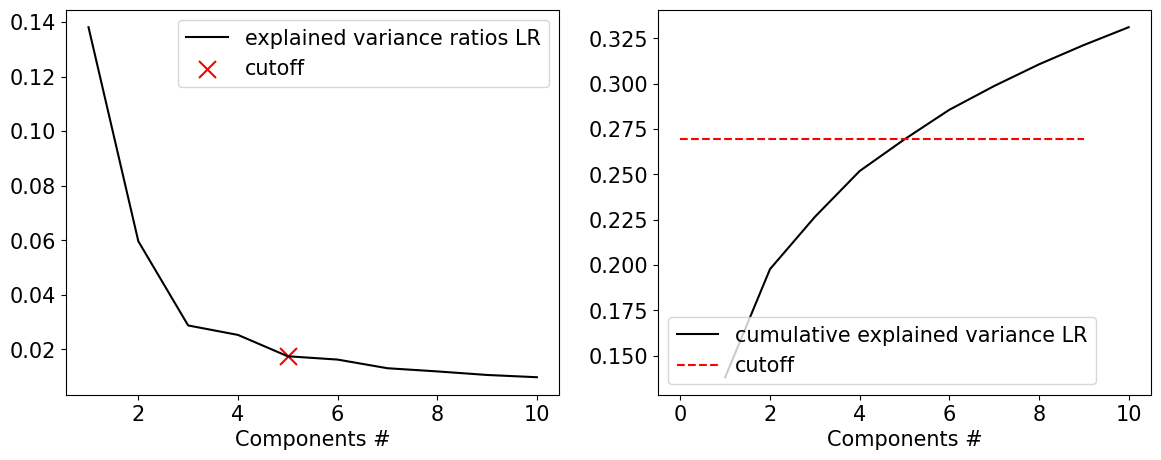

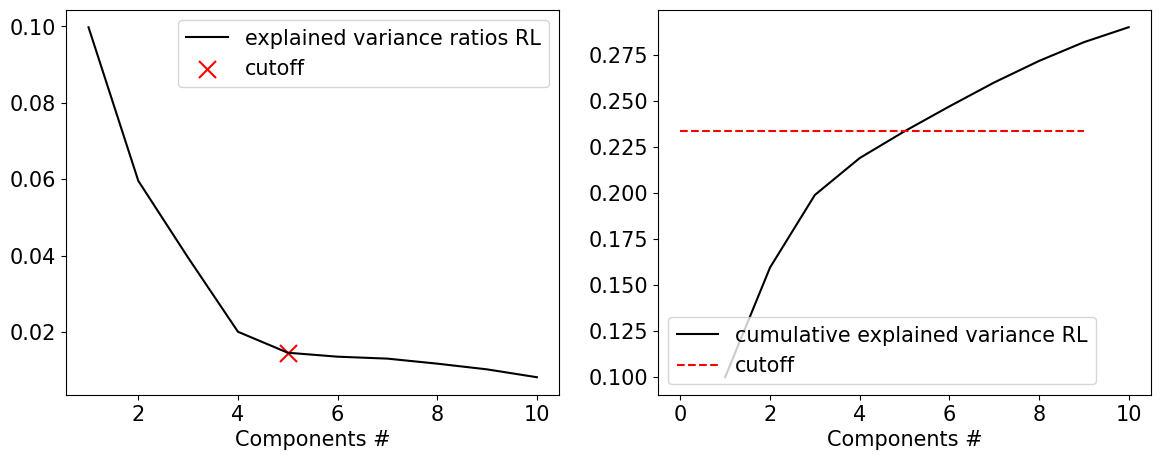

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

ratios_LR = pca_LR.explained_variance_ratio_
cumulative_ratios_LR = np.cumsum(pca_LR.explained_variance_ratio_)
nb_clusters = 5

ax[0].plot(np.arange(1, len(ratios_LR)+1), ratios_LR, label='explained variance ratios LR', c='k')
ax[0].scatter([nb_clusters], [ratios_LR[nb_clusters-1]], [150], marker='x', color='r', label='cutoff')
ax[1].plot(np.arange(1, len(cumulative_ratios_LR)+1), cumulative_ratios_LR, label='cumulative explained variance LR', c='k')
ax[1].hlines(y=cumulative_ratios_LR[nb_clusters-1], xmin=0, xmax=len(ratios_LR)-1, linestyle='--', color='r', label='cutoff')

for k in range(2):
    ax[k].set_xlabel('Components #', size=15)
    ax[k].legend(prop={'size':15})
    ax[k].tick_params(axis='both', which='major', labelsize=15)

fig, ax = plt.subplots(1, 2, figsize=(14,5))

ratios_RL = pca_RL.explained_variance_ratio_
cumulative_ratios_RL = np.cumsum(pca_RL.explained_variance_ratio_)
nb_clusters = 5

ax[0].plot(np.arange(1, len(ratios_RL)+1), ratios_RL, label='explained variance ratios RL', c='k')
ax[0].scatter([nb_clusters], [ratios_RL[nb_clusters-1]], [150], marker='x', color='r', label='cutoff')
ax[1].plot(np.arange(1, len(cumulative_ratios_RL)+1), cumulative_ratios_RL, label='cumulative explained variance RL', c='k')
ax[1].hlines(y=cumulative_ratios_RL[nb_clusters-1], xmin=0, xmax=len(ratios_RL)-1, linestyle='--', color='r', label='cutoff')

for k in range(2):
    ax[k].set_xlabel('Components #', size=15)
    ax[k].legend(prop={'size':15})
    ax[k].tick_params(axis='both', which='major', labelsize=15)

We recover the spatial domain

In [8]:
pca_clusters_LR = [] 
for cluster_idx in range(nb_clusters):
    pca_component_LR = np.zeros(vol_shape_LR)
    pca_component_LR[slice_non_background_LR] = pca_LR.components_[cluster_idx]
    pca_clusters_LR.append(pca_component_LR)

pca_clusters_RL = [] 
for cluster_idx in range(nb_clusters):
    pca_component_RL = np.zeros(vol_shape_RL)
    pca_component_RL[slice_non_background_RL] = pca_RL.components_[cluster_idx]
    pca_clusters_RL.append(pca_component_RL)



## Here we are only visualizing the first component, change it by selecting the right visual_idx

Visualize the results

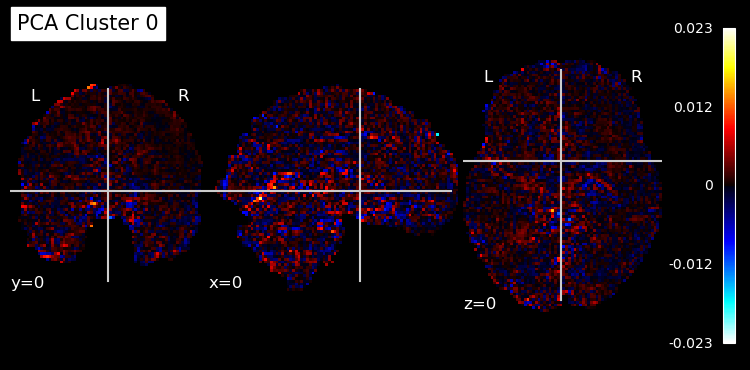

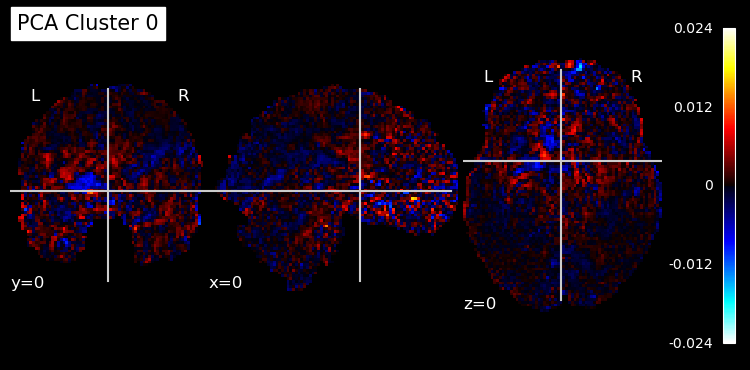

In [11]:
mean_img_LR = mean_img(fmri_LR_img_nii)
visual_idx = 0
plot_stat_map(nib.Nifti1Image(pca_clusters_LR[visual_idx], affine_LR), bg_img=mean_img_LR, threshold=0,
               cut_coords=[0,0,0], black_bg=True,
              title=f'PCA Cluster {visual_idx}')

plt.show()

mean_img_RL = mean_img(fmri_RL_img_nii)
plot_stat_map(nib.Nifti1Image(pca_clusters_RL[visual_idx], affine_RL), bg_img=mean_img_RL, threshold=0,
               cut_coords=[0,0,0], black_bg=True,
              title=f'PCA Cluster {visual_idx}')

plt.show()

## 3. Compute pairwise similarity

In [ ]:
pca_clusters_LR = pca_clusters_LR[:5]
pca_clusters_RL = pca_clusters_RL[:5]

pca_clusters_LR = np.array(pca_clusters_LR)
pca_clusters_RL = np.array(pca_clusters_RL)

pca_clusters_LR = pca_clusters_LR.astype('float32')

R_LR = np.dot(pca_clusters_LR, pca_clusters_LR.T)
R_RL = np.dot(pca_clusters_RL, pca_clusters_RL.T)

plt.figure(figsize=(6, 5))
sns.heatmap(R_LR, annot=True, cmap='coolwarm', center=0, square=True)
plt.title("Correlation Matrix LR")
plt.show()

plt.figure(figsize=(6, 5))
sns.heatmap(R_RL, annot=True, cmap='coolwarm', center=0, square=True)
plt.title("Correlation Matrix RL")
plt.show()